In [62]:
import pandas as pd
import numpy as np
import enum
import matplotlib.pyplot as plt
import time

In [2]:
path = "D:/TestAdvisor/Analyzers/Data/RawData/USDJPY/2015.01.02_2015.12.30.json"
df = pd.read_json(path)
df.columns = map(str.capitalize, df.columns)
df['Current'] = pd.to_datetime(df['Current'])
df = df.set_index('Current')

In [3]:
def interpolate(df: pd.DataFrame, start_index, end_index, crop=True) -> pd.DataFrame:

    """
    DataframeにNaneとして入っている欠損値を補完
    df: DataFrame
    start_index: 補完開始インデックス start_indexのデータがない場合は補完しない
    end_index: 補完終了インデックス
    """
    
    # 欠損値を補完
    df.loc[(df.index >= start_index) & (df.index <= end_index), df.columns] = df.loc[(df.index >= start_index) & (df.index <= end_index), df.columns].interpolate()
    # start_index~end_indexの範囲外のデータを削除
    if crop:
        df = df.loc[(df.index >= start_index) & (df.index <= end_index)]
    return df

In [4]:
def interpolate_df(df: pd.DataFrame):
    index = 0
    while index + 1 < len(df.index):
        new_minute_data = df.iloc[index]
        if index != df.index[-1]:
            current_time = df.index[index]
            next_time = df.index[index+1]
            time_delta = next_time - current_time
            # dataに抜けが存在する場合で期間が一日以下の場合これを補完する
            if time_delta > pd.Timedelta(minutes=1) and time_delta < pd.Timedelta(days=1):
                #print("Data is missing at", current_time, "to", next_time, "Data will be interpolated.", end="", flush=True)
                # 抜けている分のデータをnoneで埋めて作成
                none_df = pd.DataFrame(index=pd.date_range(current_time+pd.Timedelta(minutes=1), next_time-pd.Timedelta(minutes=1), freq='1min'))
                none_df['Current'] = none_df.index
                none_df['Current'] = pd.to_datetime(none_df['Current'])
                none_df = none_df.set_index('Current')
                none_df = none_df.interpolate()
                df = pd.concat([df, none_df], ignore_index=False)
                df = df.sort_index()
                df = interpolate(df, current_time, next_time, False)
        index += 1
    
    df = df.reset_index(drop=False)
    df = df.set_index("Current")
    return df

In [14]:
class OrderType(enum.Enum):
    NONE = 0
    BUY = 1
    SELL = 2
    CHECKOUT = 3

class Order:
    time: pd.Timestamp
    value: float
    order_type: OrderType
    checkout_time: pd.Timestamp

    def __init__(self, time: pd.Timestamp, value: float, order_type: OrderType):
        self.time = time
        self.value = value
        self.order_type = order_type
    
    def __str__(self):
        return f"Time: {self.time}, Value: {self.value}, OrderType: {self.order_type}"
    
    # 現在の価格と比較しての損益を計算する
    def calculate_profit(self, current_price, spread):
        if self.order_type == OrderType.BUY:
            return current_price - self.value - spread
        elif self.order_type == OrderType.SELL:
            return self.value - current_price - spread
        else:
            return 0
        
    def checkout(self, time: pd.Timestamp, current_price, spread) -> float:
        """
        ポジションの決済   
        time: 決済時間   
        return: 損益(pip)   
        """
        self.checkout_time = time
        return self.calculate_profit(current_price, spread)

In [43]:
orders = []
current_order: Order = None
first_time = None

def take_action(value: float, spread: float, time: pd.Timestamp, order_type: OrderType) -> tuple:
    """
    現在の価格と行う場合は注文を受け取り、注文を行う   
    ここの報酬を変えることによって行動の評価を変えることができる   
    つまりここはルールと報酬を決める部分である   
    value: 現在の価格   
    spread: スプレッド   
    order_time: 現在の時間   
    order_type: 注文の種類   
    returns: (行動の報酬, 利益)
    """
    global current_order
    global orders
    global first_time

    if first_time is None:
        first_time = time
    
    # 注文をして一定時間放置しているときrewardを減らしていく、つまり利確圧力を加えていく
    limit_time = pd.Timedelta(minutes=180)
    # 最後の注文のCheckoutから一定時間すぎるときの報酬を減らしていく
    limit_time_after_checkout = pd.Timedelta(minutes=120)
    
    if current_order is None:
        if order_type == OrderType.BUY:
            current_order = Order(time, value, OrderType.BUY)
            print("Buy order is taken at", time)
            return 0, 0
        elif order_type == OrderType.SELL:
            current_order = Order(time, value, OrderType.SELL)
            print("Sell order is taken at", time)
            return 0, 0
        elif order_type == OrderType.CHECKOUT:
            print("There is no order to checkout")
            return -100, 0
        elif order_type == OrderType.NONE:
            # 最後の注文から一定時間経過している場合は報酬を減らしていく
            if len(orders) > 0:
                last_order: Order = orders[-1]
                order_time_delta: pd.Timedelta = time - last_order.checkout_time
                if order_time_delta > limit_time_after_checkout:
                    return -10, 0
            else:
                # first_timeから一定時間経過している場合は報酬を減らしていく
                # 何も買わずに終えるのを防ぐため
                order_time_delta: pd.Timedelta = time - first_time
                if order_time_delta > limit_time_after_checkout:
                    return -10, 0
    else:
        if order_type == OrderType.CHECKOUT:
            profit = current_order.checkout(time, value, spread)
            print("Checkout order is taken at", time, "Profit is", profit)
            orders.append(current_order)
            current_order = None
            return profit, profit
        elif order_type == OrderType.BUY or order_type == OrderType.SELL:
            # ポジションは１つしか許容しないため、報酬を下げる
            return -100, 0
        elif order_type == OrderType.NONE:
            # limit_timeを超えた場合で、注文の現在の利益がマイナスの場合はこれと時間に応じて報酬を減らしていく
            order_time_delta: pd.Timedelta = time - current_order.time
            if order_time_delta > limit_time:
                profit = current_order.calculate_profit(value, spread)
                if profit < 0:
                    # 一定時間経過しても利益が出ない場合は報酬を減らしていく
                    return (-100 * -profit) - (10 * order_time_delta.seconds / 60), 0
                else:
                    # 利益が出ている場合も一定時間経過しているため報酬を減らしていく
                    return - (10 * order_time_delta.seconds / 60), 0
            else:
                # 一定時間経過していない場合の処理はとりあえずなし
                pass
                
    return 0, 0


In [64]:
def get_state(sequence_data: pd.DataFrame, sequence_length=1440) -> np.array:
    """
    現在の値動きの状態とorderの状態を取得する   
    returnのprofit軸とorder_type軸はcurrentorderが無い時間は0で埋める   
    sequence_data: -sequence_length分から現在のデータフレーム   
    sequence_length: この長さにトリミングして返す      
    returns: [[close(-sequence_length), ... close(current)],    
            [profit(-sequence_length), ... profit(current)],   
            [order_type(-sequence_length), ... order_type(current)]]  
    """
    global current_order
    global orders

    
    times = np.array(sequence_data.index[:-sequence_length])
    closes = np.array(sequence_data['Close'].values[:-sequence_length])
    spreads = np.array(sequence_data['Spread'].values[:-sequence_length])
    profits = np.zeros(sequence_length)
    order_type = np.zeros(sequence_length)
    
    # 利益は 0,0,0,... ,(order), profit(0), profit(1)となる
    if current_order is not None:
        profits = [current_order.calturate_profit(c, s) if t >= current_order.time else 0 for c, s, t in zip(closes, spreads, times)]
        
    # 過去の注文がある場合もそれを埋める
    for order in orders:
        old_profits = [order.calturate_profit(c, s) if t >= order.time and t <= order.checkout_time else p for c, s, t, p in zip(closes, spreads, times, profits)]
        profits = [max(p, op) for p, op in zip(profits, old_profits)]

    # 注文の種類は 0,0,0,... ,(order), order_type(0), order_type(1)となる
    if current_order is not None:
        order_type = [current_order.order_type.value if t >= current_order.time else 0 for t in times]
    
    # 過去の注文がある場合もそれを埋める
    for order in orders:
        old_order_type = [order.order_type.value if t >= order.time and t <= order.checkout_time else ot for t, ot in zip(times, order_type)]
        order_type = [max(ot, oot) for ot, oot in zip(order_type, old_order_type)]

    return np.array([times, closes, profits, order_type])

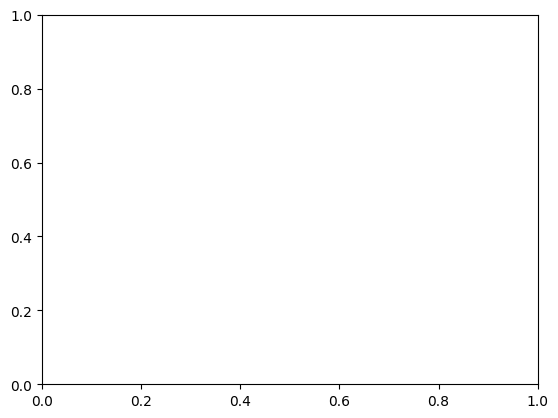

In [60]:

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
def update_graph(state: np.array):
    """
    状態をグラフに描画する
    """
    global ax
    ax.clear()
    times = state[0]
    closes = state[1]
    profits = state[2]
    order_type = state[3]

    ax.plot(times, closes, label="Close")
    ax.bar(times, profits, label="Profit")
    ax.bar(times, order_type, label="OrderType")
    plt.legend()
    plt.show()
    



In [63]:
def loop(test_actions: dict):
    global current_order
    global orders
    global interpolated_data

    sequence_length = 2880

    for i in range(0, len(interpolated_data) - sequence_length, 1):
        sequence = interpolated_data[i:i+sequence_length]

        now = sequence.index[-1]
        close = sequence.iloc[-1]['Close']
        spread = sequence.iloc[-1]['Spread']

        order_type = test_actions.get(time, OrderType.NONE)
        print("Time:", now, "Close:", close, "OrderType:", order_type)
        reward, profit = take_action(close, spread, now, order_type)

        state = get_state(sequence)
        update_graph(state)
        time.sleep(0.1)

In [22]:
test_actions = {
    pd.Timestamp("2015-01-06 12:00:00"): OrderType.BUY,
    pd.Timestamp("2015-01-02 12:05:00"): OrderType.CHECKOUT,
    pd.Timestamp("2015-01-02 12:06:00"): OrderType.SELL,
    pd.Timestamp("2015-01-02 12:16:00"): OrderType.CHECKOUT,
}


In [40]:
pips = 0.01
interpolated_data = interpolate_df(df)
interpolated_data.loc[:, 'Close'] = interpolated_data.loc[:, 'Close'] / pips
interpolated_data.loc[:, 'High'] = interpolated_data.loc[:, 'High'] / pips
interpolated_data.loc[:, 'Low'] = interpolated_data.loc[:, 'Low'] / pips
interpolated_data.loc[:, 'Open'] = interpolated_data.loc[:, 'Open'] / pips
interpolated_data.loc[:, 'Spread'] = interpolated_data.loc[:, 'Spread'] / pips

Time: 2015-01-06 08:06:00 Close: 11890.6 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


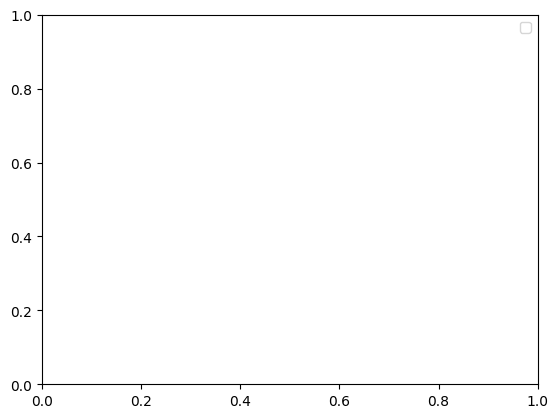

Time: 2015-01-06 08:07:00 Close: 11893.2 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


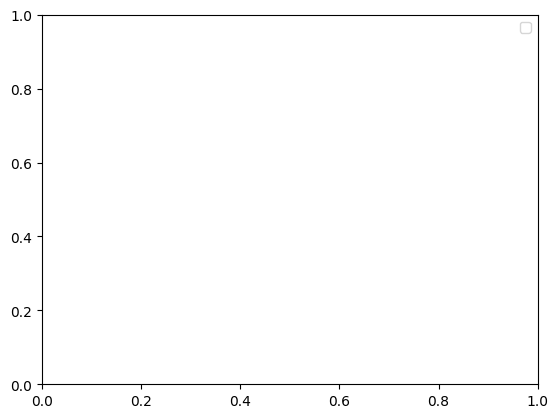

Time: 2015-01-06 08:08:00 Close: 11892.9 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


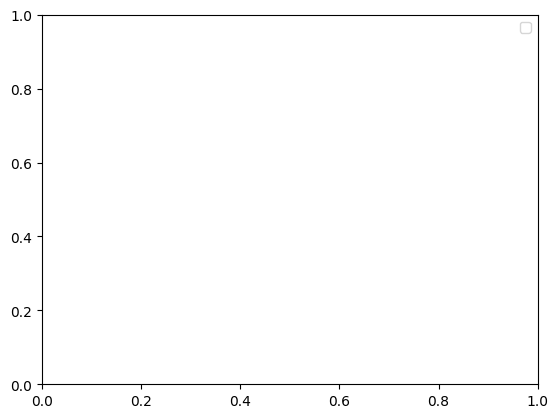

Time: 2015-01-06 08:09:00 Close: 11897.8 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


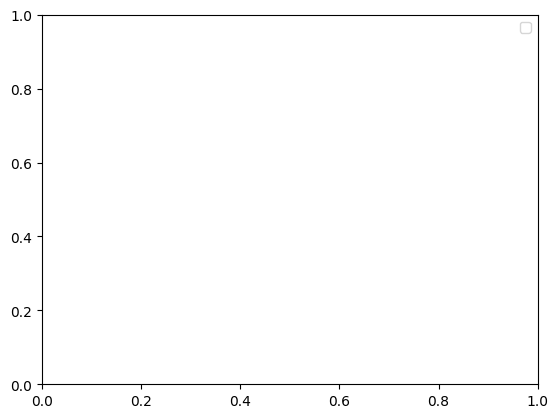

Time: 2015-01-06 08:10:00 Close: 11897.1 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


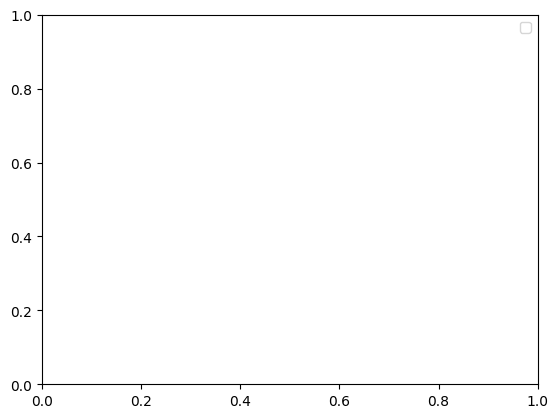

Time: 2015-01-06 08:11:00 Close: 11900.4 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


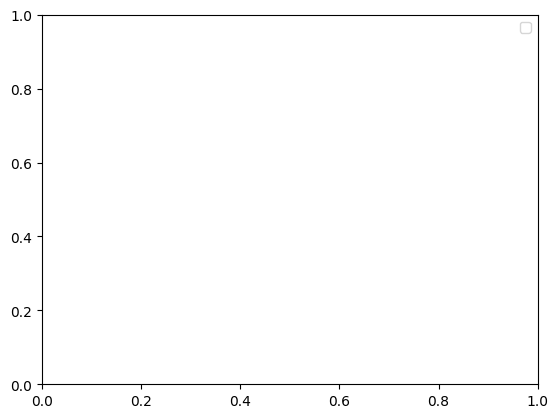

Time: 2015-01-06 08:12:00 Close: 11901.5 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


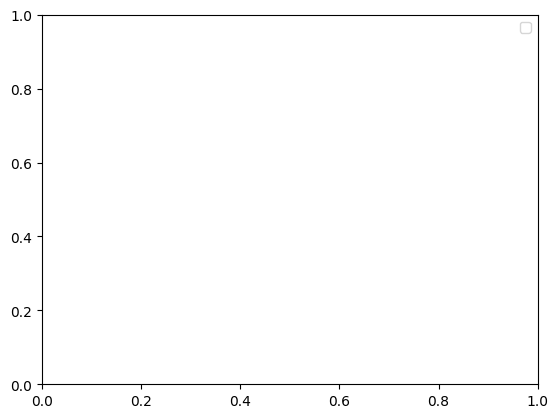

Time: 2015-01-06 08:13:00 Close: 11898.199999999999 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


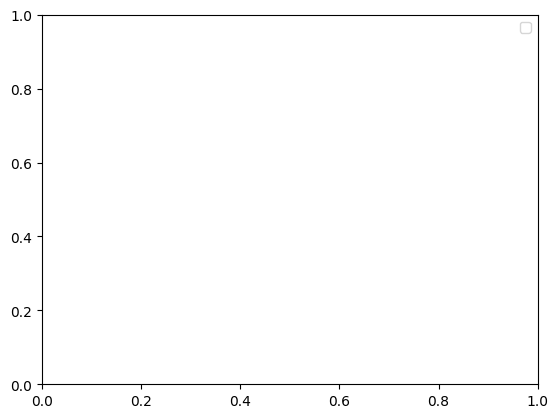

Time: 2015-01-06 08:14:00 Close: 11898.0 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


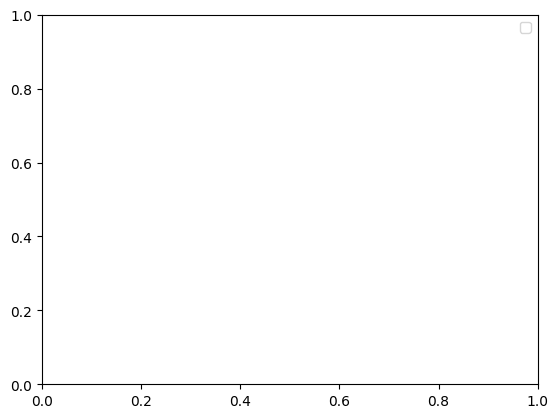

Time: 2015-01-06 08:15:00 Close: 11900.1 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


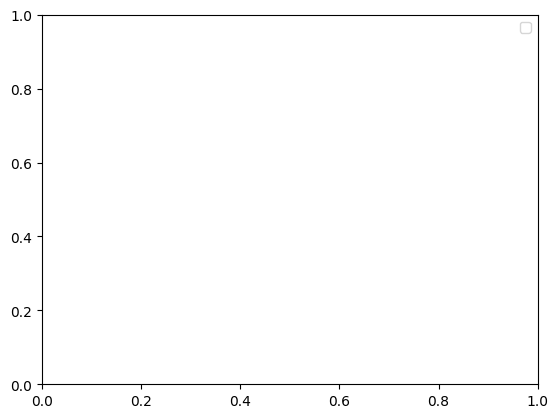

Time: 2015-01-06 08:16:00 Close: 11899.0 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


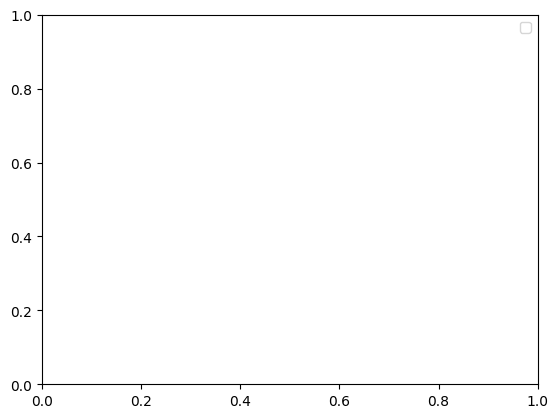

Time: 2015-01-06 08:17:00 Close: 11894.7 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


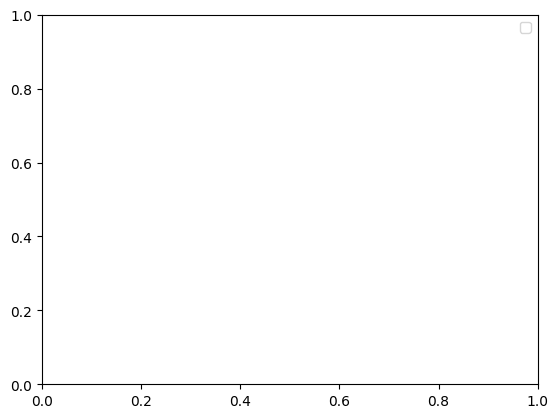

Time: 2015-01-06 08:18:00 Close: 11895.9 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


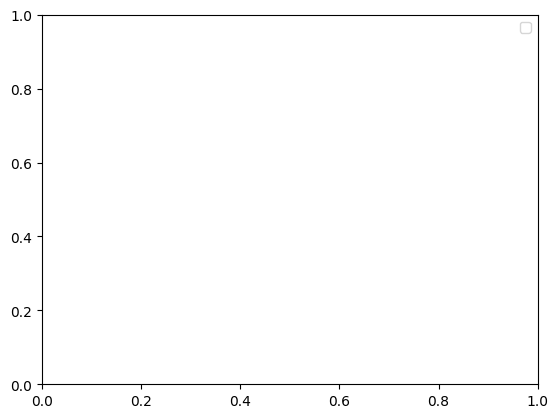

Time: 2015-01-06 08:19:00 Close: 11895.0 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


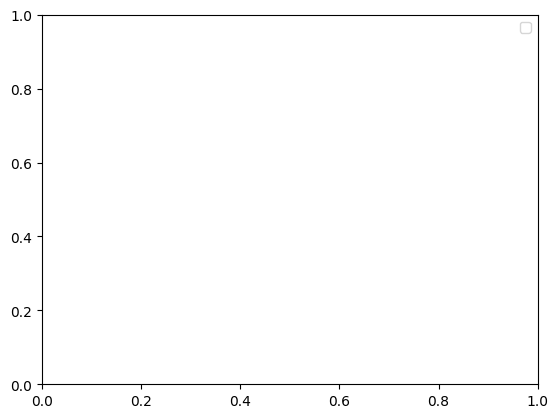

Time: 2015-01-06 08:20:00 Close: 11896.3 OrderType: OrderType.NONE


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


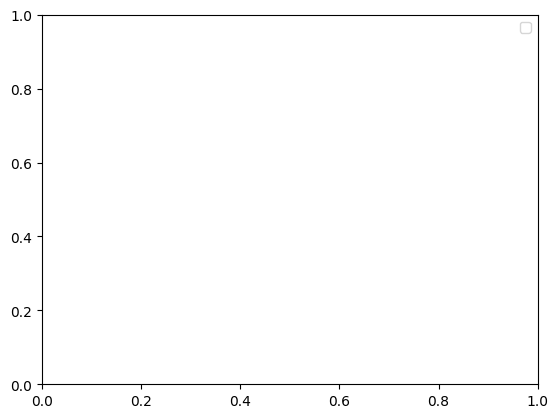

KeyboardInterrupt: 

In [65]:
loop(test_actions)

In [ ]:
def resample_df(df: pd.DataFrame) -> pd.DataFrame:
    # ---------------------------------------
    # dfを使った高速な処理の案
    # ---------------------------------------
    sequence_length = 1440
    m1_data = [df.iloc[i-sequence_length+1:i+1] for i in np.arange(sequence_length, len(df.index))]
    times = [df.iloc[i].Current for i in np.arange(sequence_length, len(df.index))]
    times = np.array(times)
    times_df = pd.DataFrame(times, columns=["timestamp"])
    times_df['week'] = times_df['timestamp'].dt.isocalendar().week
    grouped = times_df.groupby('week')
    weeks_index = [group.index.tolist() for name, group in grouped]

    agg_args = {
    "Open": "first",
    "High": "max",
    "Low": "min",
    "Close": "last",
    "Volume": "sum",
    "Spread": "mean"
    }
    for week_index in weeks_index:
        times_week = times[week_index]
        m1_data_week = [m1_data[i] for i in week_index]
        m5_week = [m1_week[i].resample('5min').agg(agg_args) for i, m1_week in enumerate(m1_data_week)]
        m10_week = [m1_week[i].resample('10min').agg(agg_args) for i, m1_week in enumerate(m1_data_week)]
        m15_week = [m1_week[i].resample('15min').agg(agg_args) for i, m1_week in enumerate(m1_data_week)]
        m30_week = [m1_week[i].resample('30min').agg(agg_args) for i, m1_week in enumerate(m1_data_week)]
        h1_week = [m1_week[i].resample('1h').agg(agg_args) for i, m1_week in enumerate(m1_data_week)]
        # times_weekをindexとしてまとめたdfを作成して保存